STEP 1: Libraries Install & Import

In [1]:
!pip install transformers gradio torch pandas scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import gradio as gr


STEP 2: Load & Preprocess Dataset

In [4]:
# Load your dataset (update the path if needed)
df = pd.read_csv('/content/go_emotions_dataset.csv')

# List all emotion columns (as per your dataframe)
emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
    'remorse', 'sadness', 'surprise', 'neutral'
]

# Remove NaN texts
df = df.dropna(subset=['text'])

# Features & labels
X = df['text'].tolist()
y = df[emotion_columns].values.astype(np.float32)

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42)


STEP 3: Tokenizer & Dataset Loader

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 64

class GoEmotionsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=MAX_LEN,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.FloatTensor(self.labels[idx])
        return item

train_dataset = GoEmotionsDataset(X_train, y_train)
val_dataset = GoEmotionsDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

STEP 4: Model Setup

In [7]:
import torch.nn as nn
class MultiLabelBERT(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(emotion_columns)
model = MultiLabelBERT(num_labels).to(device)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

STEP 5: Training Loop

In [8]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.BCEWithLogitsLoss()
epochs = 1  # Try 2 first, increase if needed

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")




Epoch 1/1 - Loss: 0.1187


In [10]:
from google.colab import files
torch.save(model.state_dict(), "/content/model_trained.pth")
files.download("/content/model_trained.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Code to Evaluate on Validation Set and Plot Confusion Matrix per Label



Hamming Loss: 0.03815745869431426
Micro F1 Score: 0.31732107205517573
Macro F1 Score: 0.22623519532749928
Micro Precision: 0.6488124690747155
Micro Recall: 0.21001841915592215


<ipython-input-11-7d0cf0929863>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'Predicted Positive', 'Predicted Negative'])
<ipython-input-11-7d0cf0929863>:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'Actual Positive', 'Actual Negative'])


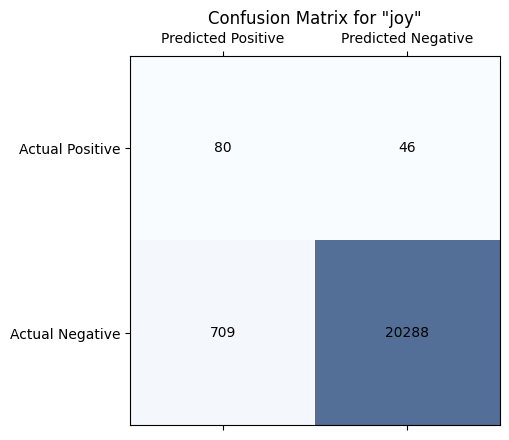

<ipython-input-11-7d0cf0929863>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'Predicted Positive', 'Predicted Negative'])
<ipython-input-11-7d0cf0929863>:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'Actual Positive', 'Actual Negative'])


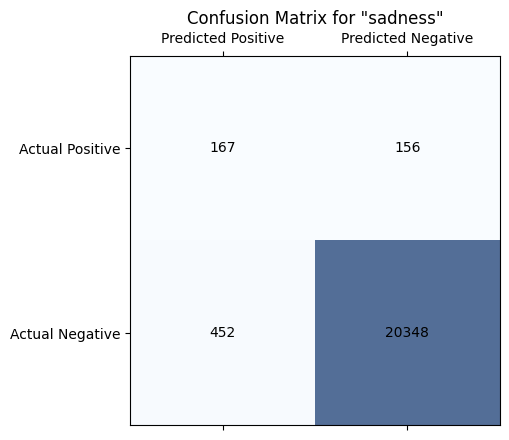

<ipython-input-11-7d0cf0929863>:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', 'Predicted Positive', 'Predicted Negative'])
<ipython-input-11-7d0cf0929863>:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', 'Actual Positive', 'Actual Negative'])


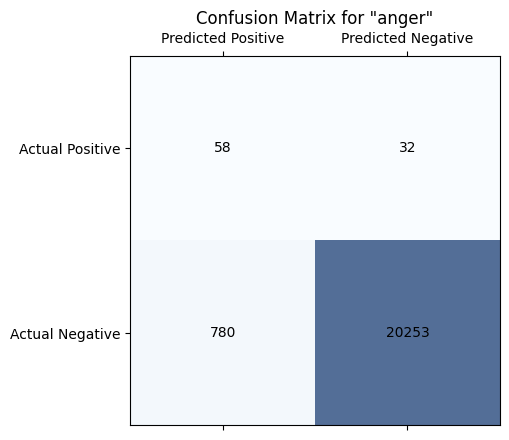

In [11]:
from sklearn.metrics import f1_score, hamming_loss, precision_score, recall_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()

        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_preds.append(preds)
        all_labels.append(labels)

all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Metrics
print("Hamming Loss:", hamming_loss(all_labels, all_preds))
print("Micro F1 Score:", f1_score(all_labels, all_preds, average='micro'))
print("Macro F1 Score:", f1_score(all_labels, all_preds, average='macro'))
print("Micro Precision:", precision_score(all_labels, all_preds, average='micro'))
print("Micro Recall:", recall_score(all_labels, all_preds, average='micro'))

# Confusion matrices per class
cm = multilabel_confusion_matrix(all_labels, all_preds)

# Plot confusion matrix for a few emotions
def plot_confusion_matrix_per_label(cm, labels, indices):
    for i in indices:
        tn, fp, fn, tp = cm[i].ravel()
        fig, ax = plt.subplots()
        matrix = np.array([[tp, fp],[fn, tn]])
        ax.matshow(matrix, cmap=plt.cm.Blues, alpha=0.7)
        for (j,k), val in np.ndenumerate(matrix):
            ax.text(k, j, val, ha='center', va='center')
        ax.set_xticklabels(['', 'Predicted Positive', 'Predicted Negative'])
        ax.set_yticklabels(['', 'Actual Positive', 'Actual Negative'])
        plt.title(f'Confusion Matrix for "{labels[i]}"')
        plt.show()

# Plot confusion matrices for some emotions (e.g. joy, sadness, anger)
indices_to_plot = [emotion_columns.index(e) for e in ['joy', 'sadness', 'anger']]
plot_confusion_matrix_per_label(cm, emotion_columns, indices_to_plot)


Manual Testing of Examples

In [15]:
test_sentences = [
    "I am so happy and grateful for your help!",
    "I feel so sad and alone right now.",
    "I am very angry and disappointed.",
    "Wow! That was such a surprise!",
    "I am confused but curious."
]

def predict(text):
    model.eval()
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=64)
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()[0]
    pred_labels = [idx2emotion[i] for i, p in enumerate(probs) if p > 0.5]
    return pred_labels

for sent in test_sentences:
    preds = predict(sent)
    print(f"Text: {sent}")
    print(f"Predicted Emotions: {preds}")
    print("-" * 50)


Text: I am so happy and grateful for your help!
Predicted Emotions: ['joy']
--------------------------------------------------
Text: I feel so sad and alone right now.
Predicted Emotions: ['sadness']
--------------------------------------------------
Text: I am very angry and disappointed.
Predicted Emotions: ['anger']
--------------------------------------------------
Text: Wow! That was such a surprise!
Predicted Emotions: ['surprise']
--------------------------------------------------
Text: I am confused but curious.
Predicted Emotions: ['confusion']
--------------------------------------------------


STEP 6: Inference Helpers

In [14]:
idx2emotion = {i: e for i, e in enumerate(emotion_columns)}
emotion2emoji = {
    'admiration': "👏", 'amusement': "😂", 'anger': "😡", 'annoyance': "😒", 'approval': "👍",
    'caring': "🤗", 'confusion': "😕", 'curiosity': "🤔", 'desire': "😍", 'disappointment': "😞",
    'disapproval': "👎", 'disgust': "🤢", 'embarrassment': "😳", 'excitement': "🤩", 'fear': "😱",
    'gratitude': "🙏", 'grief': "😭", 'joy': "😃", 'love': "❤️", 'nervousness': "😬", 'optimism': "😊",
    'pride': "😌", 'realization': "💡", 'relief': "😌", 'remorse': "😔", 'sadness': "😢",
    'surprise': "😮", 'neutral': "😐"
}


STEP 7: Gradio Interface for Prediction

In [16]:
# Load trained weights (after training)
model.load_state_dict(torch.load("/content/model_trained.pth", map_location=device))
model.eval()

def predict_emotions(text, threshold=0.5):
    tokens = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=MAX_LEN
    )
    input_ids = tokens['input_ids'].to(device)
    attention_mask = tokens['attention_mask'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()[0]
    pred_labels = [idx2emotion[i] for i, p in enumerate(probs) if p > threshold]
    if pred_labels:
        result = " | ".join([f"{emotion2emoji.get(e, '')} {e.capitalize()}" for e in pred_labels])
    else:
        result = "😐 Neutral"
    return result

iface = gr.Interface(
    fn=predict_emotions,
    inputs=gr.Textbox(lines=2, placeholder="Type your text here..."),
    outputs="text",
    title="🎭 Multi-Label Emotion Recognition",
    description="Detect multiple emotions present in your text. Each emotion is shown with an emoji. Powered by BERT!"
)
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://33a3934e823e410e63.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
